In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sympy.solvers import solve
import sympy as sp

In [5]:
"""
Set up some parameters
"""
length_density_of_panels = 31 # kg/m
max_side_panel_angle = np.pi/4
L1 = 1.15 #meters (about 4 feet)
M1 = length_density_of_panels*L1 # kg

# These values are subject to change as max angle is varied
L2 = 1/np.sin(max_side_panel_angle) #meters
M2 = length_density_of_panels*L2 # kg
print("Top panel weighs {} kg\nSide panel weighs {} kg".format(M1, M2))
g = 9.81 #m/s2

Top panel weighs 35.65 kg
Side panel weighs 43.840620433565945 kg


The order of the solution vector will be $F_{Rail-1}$, $F_{Rail-2}$, $F_{Hinge-x}$, $F_{Hinge-y}$, $M_R$, $F_{act}$ 

For theta=0, act_mount_pos=1, act_base_pos=1, sw_len = 2:	phi=0.7853981633974483
For theta=pi/6, act_mount_pos=1, act_base_pos=1, sw_len = 2:	phi=0.523598775598299


For theta=0, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, no spring:
forces=[912.33   0.     0.   304.11 304.11   0.  ]
For theta=0, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, 500 N preload:
forces=[812.33   0.     0.   204.11 204.11   0.  ]
For theta=pi/6, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, 500 N preload, 25N/m spring:
forces=[843.38154736 -31.98772499   0.         235.16154736 446.0069342
 -42.31578267]
For theta=pi/6, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, 500 N preload, 0N/m spring:
forces=[838.3575     -30.05396826   0.         230.1375     439.726875
 -39.75766297]


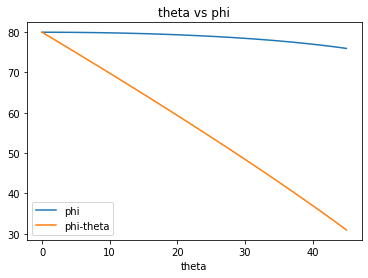

In [29]:
phi = sp.Symbol('phi')

"""
Get actuator angle from side-wall angle, actuator mounting position, distance of actuator from side-wall
act_mount_pos is defined as distance in meters from the actuator--side-wall mount and the hinge
act_base_pos is defined as distance in meters between the actuator base mount and the side-wall's
closed position. The actuator base is assumed to be flush with the top wall
sw_len is the length of the side-wall
"""
def get_phi(theta, act_mount_pos, act_base_pos, sw_len):
    return np.float64(solve((act_base_pos + (sw_len-act_mount_pos)*sp.sin(theta))*(sp.tan(phi)) - (act_mount_pos*sp.cos(theta)), phi)[0])

# Sanity check of angle geometry, phi should be pi/4 and pi/6 for these two respectively
print("For theta=0, act_mount_pos=1, act_base_pos=1, sw_len = 2:\tphi={}".format(get_phi(0,1,1,2)))
print("For theta=pi/6, act_mount_pos=1, act_base_pos=1, sw_len = 2:\tphi={}".format(get_phi(np.pi/6,1,1,2)))

ph_array = []
th_array = np.linspace(0, np.pi/4, 100)
L2 = 1/np.sin(np.pi/4) # m
d1 = 0.25
d2 = L2
for th in th_array:
    ph_array.append((180/np.pi)*get_phi(th, d2, d1, L2))
    
plt.plot((180/np.pi)*th_array, ph_array, label='phi')
plt.plot((180/np.pi)*th_array, ph_array-(180/np.pi)*th_array, label='phi-theta')

plt.title("theta vs phi")
plt.xlabel("theta")
plt.legend()
# plt.ylabel("phi")
    

"""
Get the actuator load and reaction forces from the side-wall angle
Must also provide the actuator mounting position, actuator base position, side-wall length,
top-wall mass, spring preload, spring constant
"""
def get_forces_from_angle(theta, act_mount_pos, act_base_pos, tw_len, sw_len, sp_preload, sp_const):
    M1 = tw_len*length_density_of_panels
    M2 = sw_len*length_density_of_panels
    Fs = sp_preload - sp_const*sw_len*(1-np.cos(theta))
    ph = get_phi(theta, act_mount_pos, act_base_pos, sw_len)
    R1_offset = tw_len - sw_len*np.sin(theta)# this is a distance offset of the reaction on linear rail 1. It is set to the center of the non-overhanging part
    A = np.array([
        [1, 0, 0, -1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, -(tw_len-R1_offset/2), 1, 0],
        [0, 0, 0, 1, 0, np.sin(ph)],
        [0, 1, -1, 0, 0, -np.cos(ph)],
        [0, 0, sw_len*np.cos(theta), sw_len*np.sin(theta), 0, np.cos(ph-theta)],
        ])
    B = np.array([M1*g, 
                  0, 
                  M1*g*(tw_len/2-R1_offset/2),
                  M2*g - Fs, 
                  0, 
                  M2*g*sw_len*np.sin(theta)/2])
    X = np.linalg.inv(A).dot(B)
    return X

# Sanity check, think about these conditions and see if they make sense
print("\n\nFor theta=0, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, no spring:\nforces={}".format(get_forces_from_angle(0, 1, 1, 2, 1, 0, 0)))
print("For theta=0, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, 500 N preload:\nforces={}".format(get_forces_from_angle(0, 1, 1, 2, 1, 100, 1)))
print("For theta=pi/6, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, 500 N preload, 25N/m spring:\nforces={}".format(get_forces_from_angle(np.pi/6, 1, 1, 2, 1, 100, 25)))
print("For theta=pi/6, act_mount_pos=1, act_base_pos=1, sw_len = 2, tw_len = 1, 500 N preload, 0N/m spring:\nforces={}".format(get_forces_from_angle(np.pi/6, 1, 1, 2, 1, 100, 0)))


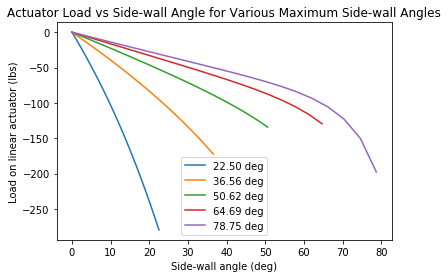

In [12]:
"""
Find axial load profiles for a range of max side-wall angles
This is with no spring, and d1,d2 = 0.5,1
"""

d1 = 0.5
d2 = 1
Fs0 = 0
K = 0
num_points = 20
num_plots = 5

all_load_profiles = {"Fr1":[],
             "Fr2":[],
             "Hx":[],
             "Hy":[],
             "Mr":[],
             "Fa":[],
             "angles":[]
            }
max_angs = []

for max_ang in np.linspace(np.pi/8, 7*np.pi/16, num_plots):
    Fr1 = []
    Fr2 = []
    Hx = []
    Hy = []
    Mr = []
    Fa = []
    angles = []
    L2 = 1/np.sin(max_ang) #meters
    for theta in np.linspace(0, max_ang, num_points):
        loads = get_forces_from_angle(theta, d2, d1, L1, L2, Fs0, K)
        Fr1.append(loads[0])
        Fr2.append(loads[1])
        Hx.append(loads[2])
        Hy.append(loads[3])
        Mr.append(loads[4])
        Fa.append(loads[5])
        angles.append(theta*180/np.pi)
    all_load_profiles["Fr1"].append(Fr1)
    all_load_profiles["Fr2"].append(Fr2)
    all_load_profiles["Hx"].append(Hx)
    all_load_profiles["Hy"].append(Hy)
    all_load_profiles["Mr"].append(Mr)
    all_load_profiles["Fa"].append(Fa)
    all_load_profiles["angles"].append(angles)
    max_angs.append(max_ang)

for angle, load, max_angle in zip(all_load_profiles["angles"], all_load_profiles["Fa"], max_angs):
    load_lbs = [l*2.2/g for l in load] # Covert N to lbs
    plt.plot(angle, load_lbs, label="{:.2f} deg".format(max_angle*180/np.pi))
plt.legend()
plt.title("Actuator Load vs Side-wall Angle for Various Maximum Side-wall Angles")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Load on linear actuator (lbs)")
plt.savefig("Spring Bifold Plots/act_loads_for_max_angs.jpg")

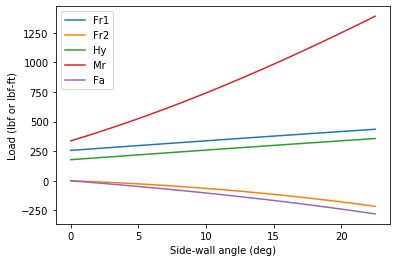

In [13]:
"""
See the magnitude of other loads (all in N or Nm)
"""
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fr1"][0]], label="Fr1")
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fr2"][0]],label="Fr2")
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Hy"][0]], label="Hy")
plt.plot(all_load_profiles["angles"][0], [load*(1/1.356) for load in all_load_profiles["Mr"][0]], label="Mr") # Nm to lbf ft
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fa"][0]], label="Fa")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Load (lbf or lbf-ft)")
plt.legend()

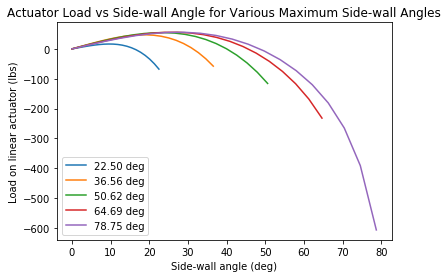

In [14]:
"""
Find axial load profiles for a range of max side-wall angles
This is with 500N spring preload with 100N/m spring const, and d1,d2 = 0.5,1
"""

d1 = 0.5 # m
d2 = 1 # m
Fs0 = 500 # N
K = 1000 # N/m
num_points = 20
num_plots = 5

all_load_profiles = {"Fr1":[],
             "Fr2":[],
             "Hx":[],
             "Hy":[],
             "Mr":[],
             "Fa":[],
             "angles":[]
            }
max_angs = []

for max_ang in np.linspace(np.pi/8, 7*np.pi/16, num_plots):
    Fr1 = []
    Fr2 = []
    Hx = []
    Hy = []
    Mr = []
    Fa = []
    angles = []
    L2 = 1/np.sin(max_ang) #meters
    for theta in np.linspace(0, max_ang, num_points):
        loads = get_forces_from_angle(theta, d2, d1, L1, L2, Fs0, K)
        Fr1.append(loads[0])
        Fr2.append(loads[1])
        Hx.append(loads[2])
        Hy.append(loads[3])
        Mr.append(loads[4])
        Fa.append(loads[5])
        angles.append(theta*180/np.pi)
    all_load_profiles["Fr1"].append(Fr1)
    all_load_profiles["Fr2"].append(Fr2)
    all_load_profiles["Hx"].append(Hx)
    all_load_profiles["Hy"].append(Hy)
    all_load_profiles["Mr"].append(Mr)
    all_load_profiles["Fa"].append(Fa)
    all_load_profiles["angles"].append(angles)
    max_angs.append(max_ang)

for angle, load, max_angle in zip(all_load_profiles["angles"], all_load_profiles["Fa"], max_angs):
    load_lbs = [l*2.2/g for l in load] # Covert N to lbs
    plt.plot(angle, load_lbs, label="{:.2f} deg".format(max_angle*180/np.pi))
plt.legend()
plt.title("Actuator Load vs Side-wall Angle for Various Maximum Side-wall Angles")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Load on linear actuator (lbs)")
plt.savefig("Spring Bifold Plots/act_loads_for_max_angs.jpg")

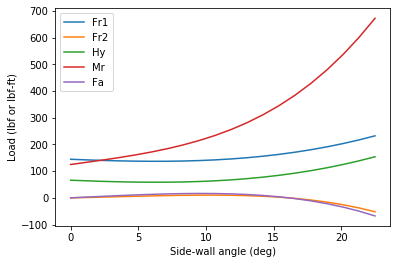

In [15]:
"""
See the magnitude of other loads (all in N or Nm)
"""
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fr1"][0]], label="Fr1")
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fr2"][0]],label="Fr2")
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Hy"][0]], label="Hy")
plt.plot(all_load_profiles["angles"][0], [load*(1/1.356) for load in all_load_profiles["Mr"][0]], label="Mr") # Nm to lbf ft
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fa"][0]], label="Fa")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Load (lbf or lbf-ft)")
plt.legend()

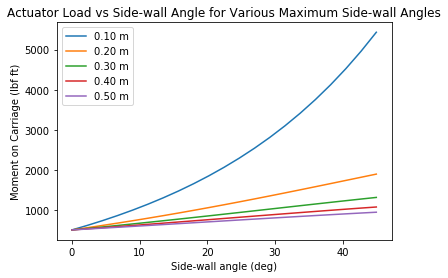

In [104]:
"""
Find moment load profiles for a range of actuator base positions
This is at max side-wall angle 45 deg with no spring, and d2 = L2/2
"""

max_ang = np.pi/4
L2 = 1/np.sin(max_ang) # m
d2 = L2/2 # m
Fs0 = 0 # N
K = 0 # N/m

num_points = 21
num_plots = 5

all_load_profiles = {"Fr1":[],
             "Fr2":[],
             "Hx":[],
             "Hy":[],
             "Mr":[],
             "Fa":[],
             "angles":[]
            }
base_pos = []

for d1 in np.linspace(0.1, 0.5, num_plots):
    Fr1 = []
    Fr2 = []
    Hx = []
    Hy = []
    Mr = []
    Fa = []
    angles = []
    for theta in np.linspace(0, max_ang, num_points):
        loads = get_forces_from_angle(theta, d2, d1, L1, L2, Fs0, K)
        Fr1.append(loads[0])
        Fr2.append(loads[1])
        Hx.append(loads[2])
        Hy.append(loads[3])
        Mr.append(loads[4])
        Fa.append(loads[5])
        angles.append(theta*180/np.pi)
    all_load_profiles["Fr1"].append(Fr1)
    all_load_profiles["Fr2"].append(Fr2)
    all_load_profiles["Hx"].append(Hx)
    all_load_profiles["Hy"].append(Hy)
    all_load_profiles["Mr"].append(Mr)
    all_load_profiles["Fa"].append(Fa)
    all_load_profiles["angles"].append(angles)
    base_pos.append(d1)

for angle, load, bp in zip(all_load_profiles["angles"], all_load_profiles["Mr"], base_pos):
    load_lbs = [l*1/1.356 for l in load] # Covert Nm to lbf ft
    plt.plot(angle, load_lbs, label="{:.2f} m".format(bp))
plt.legend()
plt.title("Actuator Load vs Side-wall Angle for Various Maximum Side-wall Angles")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Moment on Carriage (lbf ft)")
plt.savefig("Spring Bifold Plots/act_loads_for_max_angs.jpg")

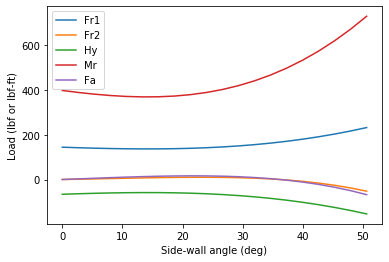

In [94]:
"""
See the magnitude of other loads (all in N or Nm)
"""
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fr1"][0]], label="Fr1")
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fr2"][0]],label="Fr2")
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Hy"][0]], label="Hy")
plt.plot(all_load_profiles["angles"][0], [load*(1/1.356) for load in all_load_profiles["Mr"][0]], label="Mr") # Nm to lbf ft
plt.plot(all_load_profiles["angles"][0], [load*(2.2/g) for load in all_load_profiles["Fa"][0]], label="Fa")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Load (lbf or lbf-ft)")
plt.legend()

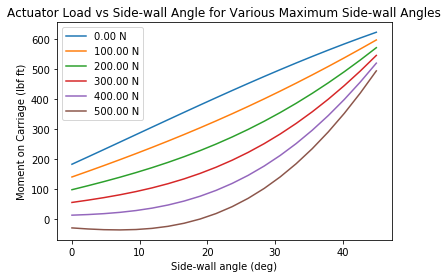

In [17]:
"""
Find moment load profiles for a range of spring preloads (spring const set such that 50cm travel results in preload)
This is at max side-wall angle 45 deg, d1 = 0.5 and d2 = L2/2
"""

max_ang = np.pi/4
L2 = 1/np.sin(max_ang) # m
d1 = 0.5
d2 = L2/2 # m
# Fs0 = 0 # N
# K = 0 # N/m

num_points = 20
num_plots = 6

all_load_profiles = {"Fr1":[],
             "Fr2":[],
             "Hx":[],
             "Hy":[],
             "Mr":[],
             "Fa":[],
             "angles":[]
            }
preloads = []

for Fs0 in np.linspace(0, 500, num_plots):
    K = Fs0/0.5
    Fr1 = []
    Fr2 = []
    Hx = []
    Hy = []
    Mr = []
    Fa = []
    angles = []
    for theta in np.linspace(0, max_ang, num_points):
        loads = get_forces_from_angle(theta, d2, d1, L1, L2, Fs0, K)
        Fr1.append(loads[0])
        Fr2.append(loads[1])
        Hx.append(loads[2])
        Hy.append(loads[3])
        Mr.append(loads[4])
        Fa.append(loads[5])
        angles.append(theta*180/np.pi)
    all_load_profiles["Fr1"].append(Fr1)
    all_load_profiles["Fr2"].append(Fr2)
    all_load_profiles["Hx"].append(Hx)
    all_load_profiles["Hy"].append(Hy)
    all_load_profiles["Mr"].append(Mr)
    all_load_profiles["Fa"].append(Fa)
    all_load_profiles["angles"].append(angles)
    preloads.append(Fs0)

for angle, load, bp in zip(all_load_profiles["angles"], all_load_profiles["Mr"], preloads):
    load_lbf_ft = [l*1/1.356 for l in load] # Covert Nm to lbf ft
    plt.plot(angle, load_lbf_ft, label="{:.2f} N".format(bp))
plt.legend()
plt.title("Actuator Load vs Side-wall Angle for Various Maximum Side-wall Angles")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Moment on Carriage (lbf ft)")
plt.savefig("Spring Bifold Plots/act_loads_for_max_angs.jpg")

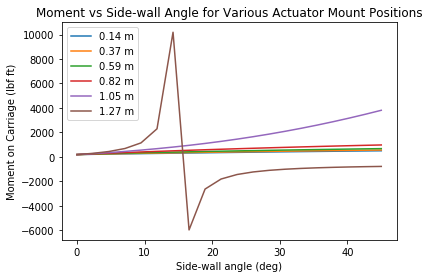

In [39]:
"""
Find moment load profiles for a range of mounting positions
This is at max side-wall angle 45 deg, d1 = 0.25,
no spring
#400N spring preloads (spring const set such that 50cm travel results in preload)
"""

max_ang = np.pi/4
L2 = 1/np.sin(max_ang) # m
d1 = 0.1
# d2 = L2/2 # m
Fs0 = 0 # N
K = Fs0/0.5 # N/m

num_points = 20
num_plots = 6

all_load_profiles = {"Fr1":[],
             "Fr2":[],
             "Hx":[],
             "Hy":[],
             "Mr":[],
             "Fa":[],
             "angles":[]
            }
mount_pos = []

for d2 in np.linspace(L2/10, 9*L2/10, num_plots):
    Fr1 = []
    Fr2 = []
    Hx = []
    Hy = []
    Mr = []
    Fa = []
    angles = []
    for theta in np.linspace(0, max_ang, num_points):
        loads = get_forces_from_angle(theta, d2, d1, L1, L2, Fs0, K)
        Fr1.append(loads[0])
        Fr2.append(loads[1])
        Hx.append(loads[2])
        Hy.append(loads[3])
        Mr.append(loads[4])
        Fa.append(loads[5])
        angles.append(theta*180/np.pi)
    all_load_profiles["Fr1"].append(Fr1)
    all_load_profiles["Fr2"].append(Fr2)
    all_load_profiles["Hx"].append(Hx)
    all_load_profiles["Hy"].append(Hy)
    all_load_profiles["Mr"].append(Mr)
    all_load_profiles["Fa"].append(Fa)
    all_load_profiles["angles"].append(angles)
    mount_pos.append(d2)

for angle, load, mp in zip(all_load_profiles["angles"], all_load_profiles["Mr"], mount_pos):
    load_lbf_ft = [l*1/1.356 for l in load] # Covert Nm to lbf ft
    plt.plot(angle, load_lbf_ft, label="{:.2f} m".format(mp))
plt.legend()
plt.title("Moment vs Side-wall Angle for Various Actuator Mount Positions")
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Moment on Carriage (lbf ft)")
plt.savefig("Spring Bifold Plots/act_loads_for_max_angs.jpg")

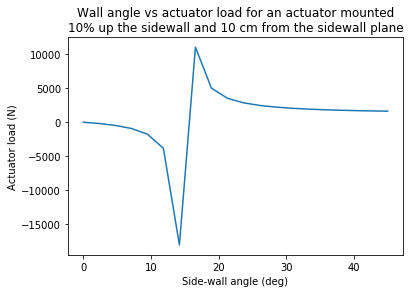

In [50]:
plt.plot(all_load_profiles["angles"][-1], all_load_profiles["Fa"][-1])
plt.xlabel("Side-wall angle (deg)")
plt.ylabel("Actuator load (N)")
plt.title("Wall angle vs actuator load for an actuator mounted\n10% up the sidewall and 10 cm from the sidewall plane")
# plt.subplots_adjust(left=0.1, right=0.8)
plt.savefig("Spring Bifold Plots/critical.jpg", bbox_inches='tight')

In [79]:
delta_sp_max = []
th_max_array = np.linspace(np.pi/8, 3*np.pi/8, 20)
L2_array = []
for th in th_max_array:
    L2_array.append(1/np.sin(th))
    delta_sp_max.append((1 - np.cos(th))/(np.sin(th)))

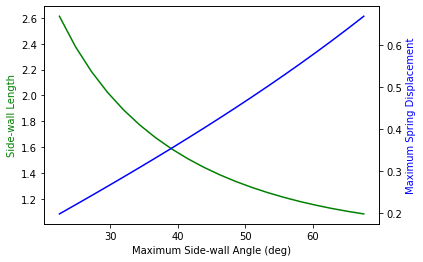

In [78]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(th_max_array*(180/np.pi), L2_array, 'g-')
ax2.plot(th_max_array*(180/np.pi), delta_sp_max, 'b-')

ax1.set_xlabel('Maximum Side-wall Angle (deg)')
ax1.set_ylabel('Side-wall Length(m)', color='g')
ax2.set_ylabel('Maximum Spring Displacement(m)', color='b')

plt.show()